# Single Elders Home Monitoring : PCA filtering

In [1]:
# needed for pyspark windows installs
import findspark
findspark.init()

import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import median_filter
import plotly
import plotly.express as px
import plotly.offline as py
import sklearn

# import custom classes/libs
from PCAWrapper import PCAWrapper

# Enable offline mode
import plotly.io as pio
pio.renderers.keys()
pio.renderers.default = 'jupyterlab' 

from pyspark.conf import SparkConf
from pyspark.sql import SparkSession 

spark = (SparkSession.
     builder.
     master('local[*]'). # leave out for cluster mode
     appName('single-elders-monitoring').
     config(conf = SparkConf()).
     getOrCreate())

from pyspark.sql.functions import col
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import col, concat, dayofmonth, hour, month, year
from pyspark.sql.functions import mean
from pyspark.sql.functions import lit

## Import datasets

In [2]:
no_occupants_url = './data/data_ref_until_2020-02-13.csv'
no_occupants_df = spark.read.csv(no_occupants_url, header=True,inferSchema=True) \
                                .where("NOT('2020-02-04' <= timestamp AND timestamp < '2020-02-06') AND NOT('2020-02-08' <= timestamp AND timestamp <'2020-02-09') ") #two weeks period from sampling start time
no_occupants_df.show()
no_occupants_df.select(F.min(no_occupants_df.timestamp).alias('start date'),F.max(no_occupants_df.timestamp).alias('end date')).show()
print('The dataset with no occupants has {} rows and {} features.'.format(no_occupants_df.count(), len(no_occupants_df.columns)))

+--------------------+-----------+--------+-------------+-------------+-----+-----+-----+-----+-------+
|           timestamp|temperature|humidity|CO2CosIRValue|CO2MG811Value| MOX1| MOX2| MOX3| MOX4|COValue|
+--------------------+-----------+--------+-------------+-------------+-----+-----+-----+-----+-------+
|2020-01-25 00:01:...|      20.64|   55.57|        121.0|        496.0|521.0|694.0|652.0|591.0|  135.0|
|2020-01-25 00:02:...|      20.64|   55.53|        122.0|        495.0|521.0|694.0|652.0|591.0|  135.0|
|2020-01-25 00:02:...|      20.62|   55.53|        121.0|        495.0|522.0|694.0|651.0|591.0|  135.0|
|2020-01-25 00:02:...|      20.62|   55.57|        121.0|        495.0|522.0|694.0|651.0|591.0|  135.0|
|2020-01-25 00:03:...|      20.62|   55.59|        121.0|        495.0|522.0|694.0|652.0|591.0|  135.0|
|2020-01-25 00:03:...|      20.62|   55.71|        121.0|        495.0|522.0|694.0|652.0|591.0|  134.0|
|2020-01-25 00:03:...|      20.62|   55.74|        121.0|       

In [3]:
occupants_url = './data/database_gas.csv'
occupants_df = spark.read.csv(occupants_url, header=True,inferSchema=True) \
                            .where("timestamp < '2020-01-25'")
occupants_df.show()
occupants_df.select(F.min(occupants_df.timestamp).alias('start date'),F.max(occupants_df.timestamp).alias('end date')).show()
print('The dataset with occupants has {} rows and {} features.'.format(occupants_df.count(), len(occupants_df.columns)))

+--------------------+-----------+--------+-------------+-------------+-----+-----+-----+-----+-------+
|           timestamp|temperature|humidity|CO2CosIRValue|CO2MG811Value| MOX1| MOX2| MOX3| MOX4|COValue|
+--------------------+-----------+--------+-------------+-------------+-----+-----+-----+-----+-------+
|2019-11-06 11:37:...|      19.48|   54.86|        128.0|        563.0|476.0|731.0|649.0|565.0|  128.0|
|2019-11-06 11:37:...|      19.59|   54.23|        129.0|        563.0|477.0|731.0|649.0|565.0|  125.0|
|2019-11-06 11:37:...|      19.63|   54.05|        128.0|        566.0|478.0|732.0|649.0|565.0|  125.0|
|2019-11-06 11:38:...|      19.64|   53.74|        128.0|        566.0|478.0|732.0|649.0|565.0|  125.0|
|2019-11-06 11:38:...|      19.67|   53.53|        128.0|        569.0|480.0|732.0|650.0|565.0|  125.0|
|2019-11-06 11:38:...|      19.67|   53.53|        126.0|        570.0|481.0|733.0|650.0|565.0|  123.0|
|2019-11-06 11:39:...|      19.67|   53.53|        128.0|       

## Sliding window median filter

In [4]:
window_size=11

# defining window
windowSpec = Window.orderBy("timestamp").partitionBy("day_month_year").rowsBetween(-window_size//2, window_size//2) #Note: we can divide partition by hours to speed up computation

# Spark doesn't have a built-in implementation of median
rolling_median_udf = F.udf(lambda x: float(np.median(x)), FloatType())

cols_to_process = no_occupants_df.columns.copy()
cols_to_process.remove('timestamp')

conversion_dict = {column: rolling_median_udf(F.collect_list(column).over(windowSpec)) for column in cols_to_process}

# filtering dataset of when no occupant is in the house
no_occupants_filtered_df = no_occupants_df.withColumn("day_month_year", concat(dayofmonth(col("timestamp")), month(col("timestamp")), year(col("timestamp"))))
no_occupants_filtered_df = no_occupants_filtered_df.withColumns(conversion_dict)
no_occupants_filtered_df.sort('timestamp').show()
print('The filtered dataset with no occupants has {} rows and {} features.'.format(no_occupants_filtered_df.count(), len(no_occupants_filtered_df.columns)))

# filtering dataset of when occupant is in the house
occupants_filtered_df = occupants_df.withColumn("day_month_year", concat(dayofmonth(col("timestamp")), month(col("timestamp")), year(col("timestamp"))))
occupants_filtered_df = occupants_filtered_df.withColumns(conversion_dict)
occupants_filtered_df.sort('timestamp').show()
print('The filtered dataset with occupants has {} rows and {} features.'.format(occupants_filtered_df.count(), len(occupants_filtered_df.columns)))


+--------------------+-----------+--------+-------------+-------------+-----+-----+-----+-----+-------+--------------+
|           timestamp|temperature|humidity|CO2CosIRValue|CO2MG811Value| MOX1| MOX2| MOX3| MOX4|COValue|day_month_year|
+--------------------+-----------+--------+-------------+-------------+-----+-----+-----+-----+-------+--------------+
|2020-01-25 00:01:...|      20.62|   55.57|        121.0|        495.0|522.0|694.0|652.0|591.0|  135.0|       2512020|
|2020-01-25 00:02:...|      20.62|   55.57|        121.0|        495.0|522.0|694.0|652.0|591.0|  135.0|       2512020|
|2020-01-25 00:02:...|      20.62|   55.58|        121.0|        495.0|522.0|694.0|652.0|591.0|  135.0|       2512020|
|2020-01-25 00:02:...|      20.62|   55.59|        121.0|        495.0|522.0|694.0|652.0|591.0|  135.0|       2512020|
|2020-01-25 00:03:...|      20.62|   55.65|        121.0|        495.0|522.0|694.0|652.0|591.0|  134.5|       2512020|
|2020-01-25 00:03:...|      20.62|   55.59|     

#### Sensors signals after median filter (plot)

In [5]:
visual_filtered_df = occupants_filtered_df.where("timestamp > '2019-11-11' AND timestamp < '2019-11-12'")

# for some reason, sensor signals are divided by this value by the authors (?)
V_divider = 210
columns_to_normalize = ['CO2CosIRValue','CO2MG811Value','MOX1','MOX2','MOX3','MOX4','COValue']
columns_to_keep = ['timestamp','temperature', 'humidity']
  
visual_filtered_df = visual_filtered_df.select([col(c) for c in columns_to_keep] + [F.round(col(c) / lit(V_divider), 4).alias(c) for c in columns_to_normalize]).orderBy('timestamp')
#occupants_filtered_df =occupants_filtered_df.select([col(c) for c in columns_to_keep] + [F.round(col(c) / lit(V_divider), 4).alias(c) for c in columns_to_normalize])
#no_occupants_filtered_df =no_occupants_filtered_df.select([col(c) for c in columns_to_keep] + [F.round(col(c) / lit(V_divider), 4).alias(c) for c in columns_to_normalize])

visual_filtered_df.show()
visual_filtered_df = visual_filtered_df.toPandas()

+--------------------+-----------+--------+-------------+-------------+------+------+------+------+-------+
|           timestamp|temperature|humidity|CO2CosIRValue|CO2MG811Value|  MOX1|  MOX2|  MOX3|  MOX4|COValue|
+--------------------+-----------+--------+-------------+-------------+------+------+------+------+-------+
|2019-11-11 00:00:...|      21.35|   48.54|       0.4857|       2.8548| 2.181|3.4619|3.2429| 2.881| 0.6857|
|2019-11-11 00:00:...|      21.32|   48.69|       0.4857|       2.8571| 2.181|3.4619|3.2429| 2.881| 0.6857|
|2019-11-11 00:00:...|      21.24|  48.845|       0.4857|       2.8571| 2.181|3.4619|3.2429| 2.881| 0.6857|
|2019-11-11 00:01:...|      21.16|    49.0|       0.4857|       2.8571| 2.181|3.4619|3.2429| 2.881| 0.6857|
|2019-11-11 00:01:...|      21.16|   49.03|       0.4857|       2.8571| 2.181|3.4619|3.2429| 2.881| 0.6881|
|2019-11-11 00:01:...|      21.16|   49.06|       0.4857|       2.8571| 2.181|3.4619|3.2429| 2.881| 0.6905|
|2019-11-11 00:02:...|     2

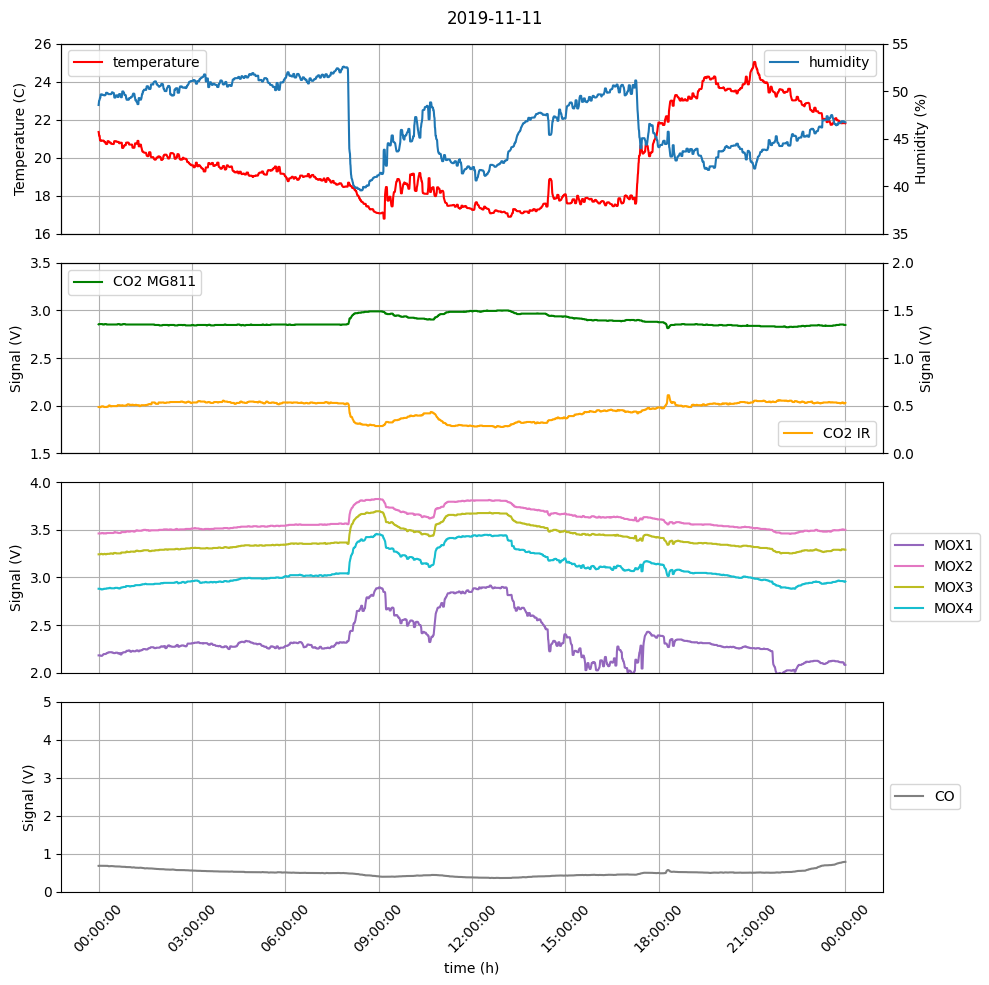

In [6]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 10))  # 4 rows, 1 column

# Plot the data in each subplot

axs[0].plot(visual_filtered_df['timestamp'], visual_filtered_df['temperature'], color='red', label='temperature')
axs[0].twin = axs[0].twinx()
axs[0].twin.plot(visual_filtered_df['timestamp'], visual_filtered_df['humidity'], label='humidity')
axs[0].twin.set_ylabel('Humidity (%)')
axs[0].set_ylabel('Temperature (C)')
axs[0].tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelbottom=False, labelleft=True)
axs[0].twin.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=True, labelbottom=False, labelleft=False)
axs[0].set_ylim(16, 26)
axs[0].twin.set_ylim(35, 55)
axs[0].grid(True)
axs[0].legend()
axs[0].twin.legend()

axs[1].plot(visual_filtered_df['timestamp'], visual_filtered_df['CO2MG811Value'], color='green', label='CO2 MG811')
axs[1].twin = axs[1].twinx()
axs[1].twin.plot(visual_filtered_df['timestamp'], visual_filtered_df['CO2CosIRValue'], color='orange', label='CO2 IR')
axs[1].twin.set_ylabel('Signal (V)')
axs[1].set_ylabel('Signal (V)')
axs[1].tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelbottom=False, labelleft=True)
axs[1].twin.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=True, labelbottom=False, labelleft=False)
axs[1].grid(True)
axs[1].set_ylim(1.5, 3.5)
axs[1].twin.set_ylim(0, 2)
axs[1].twin.legend(loc='lower right')
axs[1].legend(loc='upper left')

axs[2].plot(visual_filtered_df['timestamp'], visual_filtered_df['MOX1'], color='tab:purple', label='MOX1')
axs[2].plot(visual_filtered_df['timestamp'], visual_filtered_df['MOX2'], color='tab:pink', label='MOX2')
axs[2].plot(visual_filtered_df['timestamp'], visual_filtered_df['MOX3'], color='tab:olive', label='MOX3')
axs[2].plot(visual_filtered_df['timestamp'], visual_filtered_df['MOX4'], color='tab:cyan', label='MOX4')
axs[2].set_ylabel('Signal (V)')
axs[2].tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelbottom=False, labelleft=True)
axs[2].set_ylim(2, 4)
axs[2].grid(True)
axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[3].plot(visual_filtered_df['timestamp'], visual_filtered_df['COValue'], color='grey', label='CO')
axs[3].set_ylabel('Signal (V)')
axs[3].tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelbottom=True, labelleft=True)
axs[3].set_ylim(0, 5)
axs[3].grid(True)
axs[3].set_xlabel('time (h)')    
axs[3].legend(loc='center left', bbox_to_anchor=(1, 0.5))
date_format = DateFormatter('%H:%M:%S')
axs[3].xaxis.set_major_formatter(date_format)    
axs[3].tick_params(axis='x', labelrotation=45)

# Adjust layout
fig.suptitle('2019-11-11')
plt.tight_layout()

# Show the plots
plt.show()

## PCA fit on no occupant data

Unfortunately, the ```PCA``` implemented in Pyspark ML-lib has few features, we therefore define a ``PCAWrapper`` that, similarly to the ```scikit-learn``` PCA implementation, provides:
1. **Support for centering** 
Normalizing the data just by using the mean, *not* rescaling standard deviation to 1:
$$X_{centered} = X - \overline{X}$$
The fitting of the mean is done when calling the ```fit``` method.

3. **Support to invert the transfromation PCA projection**
We invert the transformation $$ X_{proj} = X_{centered}K$$
as
$$X_{centered_{reconstructed}} = X_{proj} \cdot K^{-1} + \overline{X} = X_{proj} \cdot K^{T} + \overline{X}$$

Naturally, if $K$, is not a square matrix (output space has same dimension of input space), the reconstruction will be lossy.

In [7]:
# pca fit
n_components = 4

# grouping features in an unique input column
assembler = VectorAssembler(inputCols = cols_to_process, outputCol = 'features')
assembled_df_no_occupants = assembler.transform(no_occupants_filtered_df)

# Define PCA model
pca = PCAWrapper(k=n_components, inputCol="features", outputCol="pcaFeatures", centering_data=True)

# Fit the model to the data
pca = pca.fit(assembled_df_no_occupants)

# Transform the data
pca_no_occupants = pca.transform(assembled_df_no_occupants).orderBy('timestamp')

var_proj = pca.explainedVariance

print('Variance explained by each dimension:\n', 
      *[f'PCA component {i+1}: {round(var_proj[i]*100,2)} % \n' for i in range (len(var_proj))])

Variance explained by each dimension:
 PCA component 1: 75.96 % 
 PCA component 2: 14.42 % 
 PCA component 3: 5.1 % 
 PCA component 4: 2.35 % 



## PCA inference

### No occupant data - before environmental correction

In [8]:
pca_no_occupants_ = pca_no_occupants.withColumn("hour", hour(pca_no_occupants.timestamp)) \
                                    .where("timestamp >= '2020-01-27' AND timestamp < '2020-02-02'") \
                                    .where("hour=0 OR hour=4 OR hour=8 OR hour=12 OR hour=16 OR hour=20")

df_visual = pca_no_occupants_.select(['timestamp','pcaFeatures']).toPandas()
visual_data = np.array(df_visual['pcaFeatures'].tolist())

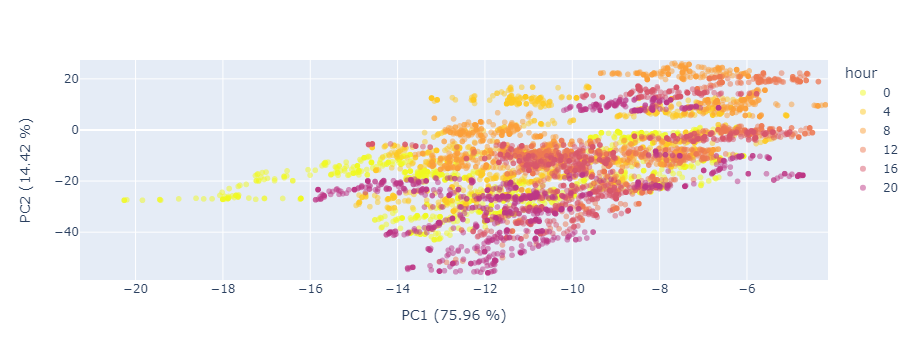

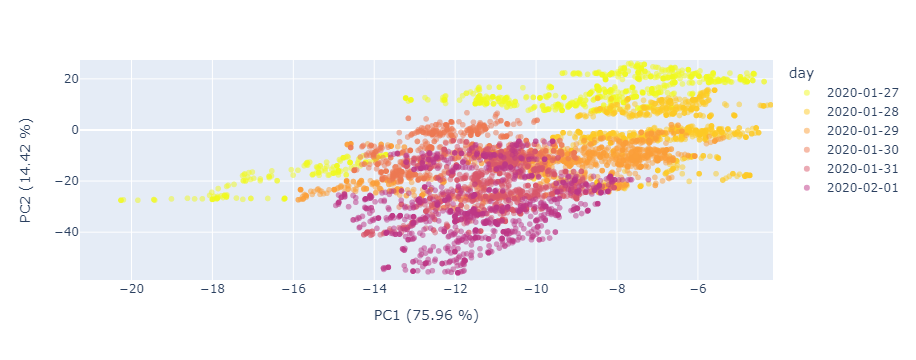

In [9]:
#visual_data = pca_no_occupants_[visual_days]
visual_data_days_df = pd.DataFrame({'PC1':visual_data[:,1], 'PC2':visual_data[:,0], 'day':pd.to_datetime(df_visual['timestamp']).dt.date})
visual_data_hours_df = pd.DataFrame({'PC1':visual_data[:,1], 'PC2':visual_data[:,0], 'hour':pd.to_datetime(df_visual['timestamp']).dt.hour.astype('str')})

## Plot no occupant data before environmental correction by hour
x_min, x_max = visual_data_hours_df['PC1'].min()*1.05, visual_data_hours_df['PC1'].max()*1.05
y_min, y_max = visual_data_hours_df['PC2'].min()*1.05, visual_data_hours_df['PC2'].max()*1.05

fig = px.scatter(visual_data_hours_df, x='PC1', y='PC2', color='hour', opacity=0.5, color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.update_traces(marker=dict(colorscale='Viridis'), selector=dict(type='scatter'))
fig.update_layout(
    xaxis_title="PC1 ({:.2f} %)".format(var_proj[0]*100),
    yaxis_title="PC2 ({:.2f} %)".format(var_proj[1]*100),
    xaxis_range=[x_min, x_max],
    yaxis_range=[y_min, y_max]  
)
fig.show()


## Plot no occupant data before environmental correction by day
fig = px.scatter(visual_data_days_df, x='PC1', y='PC2', color='day', opacity=0.5, color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.update_traces(marker=dict(colorscale='Viridis'), selector=dict(type='scatter'))
fig.update_layout(
    xaxis_title="PC1 ({:.2f} %)".format(var_proj[0]*100),
    yaxis_title="PC2 ({:.2f} %)".format(var_proj[1]*100),
    xaxis_range=[x_min, x_max],
    yaxis_range=[y_min, y_max]  
)
fig.show()

PCA space representation of the data set without human activity before environmental correction. Samples colored by time of the day (top) and colored by day (bottom). Due to environmental factors, the samples are ordered by time of the day or by the day of acquisition.

### No occupant data - after environmental correction

We build another PCA just to visually investigate the effect on no occupant data.

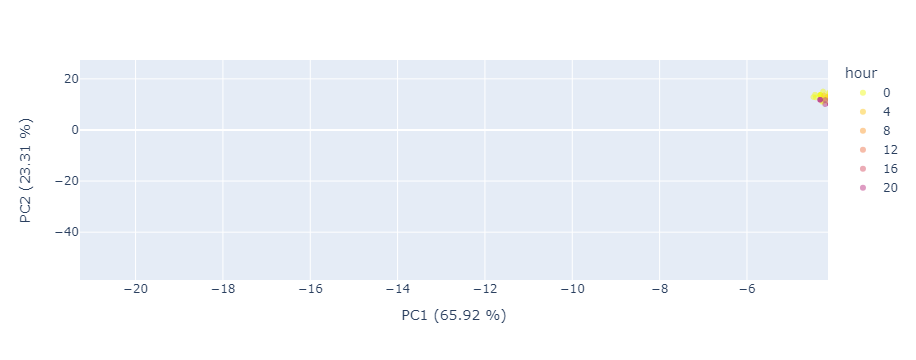

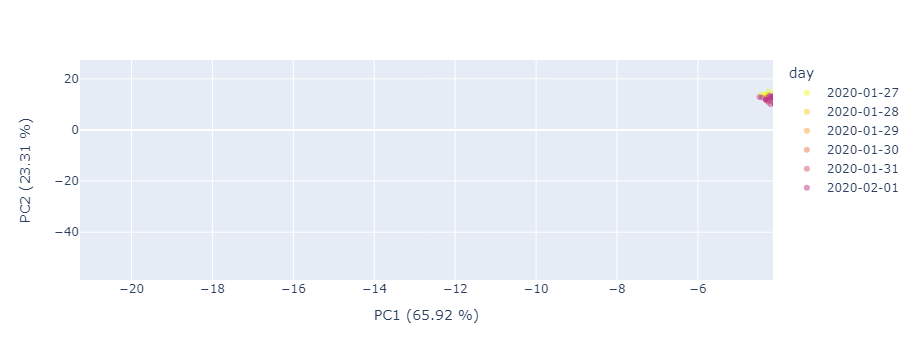

In [10]:
# unzipping vectors inside the single column to multiple columns
pca_no_occupants_unzipped = pca_no_occupants.withColumn("feature", vector_to_array("pcaFeatures")).select(["timestamp"]+[col("feature")[i] for i in range(n_components)])

# zero-ing the first component of the pca, to remove it from re-projection in the original space
pca_no_occupants_unzipped = pca_no_occupants_unzipped.withColumn('feature[0]',lit(0))

# re-zipping features into single column
invert_columns_to_convert = pca_no_occupants_unzipped.columns
invert_columns_to_convert.remove('timestamp')
assembler_invert = VectorAssembler(inputCols = invert_columns_to_convert, outputCol = 'pcaFeatures')
pca_no_occupants_zipped = assembler_invert.transform(pca_no_occupants_unzipped).select(['timestamp', 'pcaFeatures']).orderBy('timestamp')

# re-projecting to the original space
inv_transf = spark.createDataFrame(pca.inverse_transform(pca_no_occupants_zipped, schema=cols_to_process))

# Define new PCA model
pca_after_corr = PCAWrapper(k=2, inputCol="pcaFeatures", outputCol="pcaFeatures2", centering_data=True)

# Fit the model to the data
assembled_df_no_occupants_2 = assembler.transform(inv_transf)
pca_after_corr = pca_after_corr.fit(assembled_df_no_occupants_2)
var_new_proj = pca_after_corr.explainedVariance

# Transform the data
pca_no_occupants2 = pca_after_corr.transform(assembled_df_no_occupants_2)
pca_no_occupants2_ = pca_no_occupants2.withColumn("hour", hour(pca_no_occupants2.timestamp)) \
                                .where("timestamp >= '2020-01-27' AND timestamp < '2020-02-02'") \
                                .where("hour=0 OR hour=4 OR hour=8 OR hour=12 OR hour=16 OR hour=20")

df_visual2 = pca_no_occupants2_.select(['timestamp','pcaFeatures2']).toPandas()
visual_data_2 = np.array(df_visual2['pcaFeatures2'].tolist())
df_visual.head()

# Plots
    
visual_data_day_df_2 = pd.DataFrame({'PC1':visual_data_2[:,1], 'PC2':visual_data_2[:,0], 'day':pd.to_datetime(df_visual2['timestamp']).dt.date})
visual_data_hours_df_2 = pd.DataFrame({'PC1':visual_data_2[:,1], 'PC2':visual_data_2[:,0], 'hour':pd.to_datetime(df_visual2['timestamp']).dt.hour.astype('str')})

## Plot no occupant data after environmental correction by hour
fig = px.scatter(visual_data_hours_df_2, x='PC1', y='PC2', color='hour', opacity=0.5, color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.update_traces(marker=dict(colorscale='Viridis'), selector=dict(type='scatter'))
fig.update_layout(
    xaxis_title="PC1 ({:.2f} %)".format(var_new_proj[0]*100),
    yaxis_title="PC2 ({:.2f} %)".format(var_new_proj[1]*100),
    xaxis_range=[x_min, x_max],
    yaxis_range=[y_min, y_max] 
)
fig.show()

## Plot no occupant data after environmental correction by day
fig = px.scatter(visual_data_day_df_2, x='PC1', y='PC2', color='day', opacity=0.5, color_discrete_sequence= px.colors.sequential.Plasma_r)
fig.update_traces(marker=dict(colorscale='Viridis'), selector=dict(type='scatter'))
fig.update_layout(
    xaxis_title="PC1 ({:.2f} %)".format(var_new_proj[0]*100),
    yaxis_title="PC2 ({:.2f} %)".format(var_new_proj[1]*100),
    xaxis_range=[x_min, x_max],
    yaxis_range=[y_min, y_max]   
)
fig.show()

PCA space representation of the data set without human activity after environmental correction. Samples colored by time of the day (top) and colored by day (bottom). The samples overlap each other, with a reduced structure on the environmental factors.

### Occupant data - after environmental correction

We project the data with occupants in the vector space obtained by PCA on no occupant data, and we remove the first component supposing that it corresponds to noise.

In [11]:
# grouping features in an unique input column
assembled_df_occupants = assembler.transform(occupants_filtered_df).orderBy('timestamp')

# projecting features of occupant data into space generated by no occupant data
pca_occupants = pca.transform(assembled_df_occupants, fit_mean = False).orderBy('timestamp')

# unzipping vectors inside the single column to multiple columns
pca_occupants_unzipped = pca_occupants.withColumn("feature", vector_to_array("pcaFeatures")).select(['timestamp']+[col("feature")[i] for i in range(n_components)])

# zero-ing the first component of the pca, to remove it from re-projection in the original space
pca_occupants_unzipped = pca_occupants_unzipped.withColumn('feature[0]',lit(0))

# zipping vectors to a single colum
pca_occupants_zipped = assembler_invert.transform(pca_occupants_unzipped).orderBy('timestamp')

# reproject it to original space
inv_transf_occupants = spark.createDataFrame(pca.inverse_transform(pca_occupants_zipped, schema=cols_to_process))

inv_transf_occupants.show()

+--------------------+----------+-------------------+-------------------+-------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+
|           timestamp|feature[0]|         feature[1]|         feature[2]|         feature[3]|         pcaFeatures|       temperature|          humidity|     CO2CosIRValue|    CO2MG811Value|              MOX1|             MOX2|             MOX3|             MOX4|           COValue|
+--------------------+----------+-------------------+-------------------+-------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+
|2019-11-06 11:37:...|         0|-34.121852719598465| -57.96857068451881|-40.994179040670325|[0.0,-34.12185271...| 24.60596240591853|53.532676965381654|10

In [12]:
# export to csv
inv_transf_occupants_visual = inv_transf_occupants.select(['timestamp']+cols_to_process).orderBy('timestamp').toPandas()
inv_transf_occupants_visual.to_csv("./data/database_gas_after_environmental_correction.csv", sep=',', index=False)

#### Sensors signals after environmental correction (plot)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


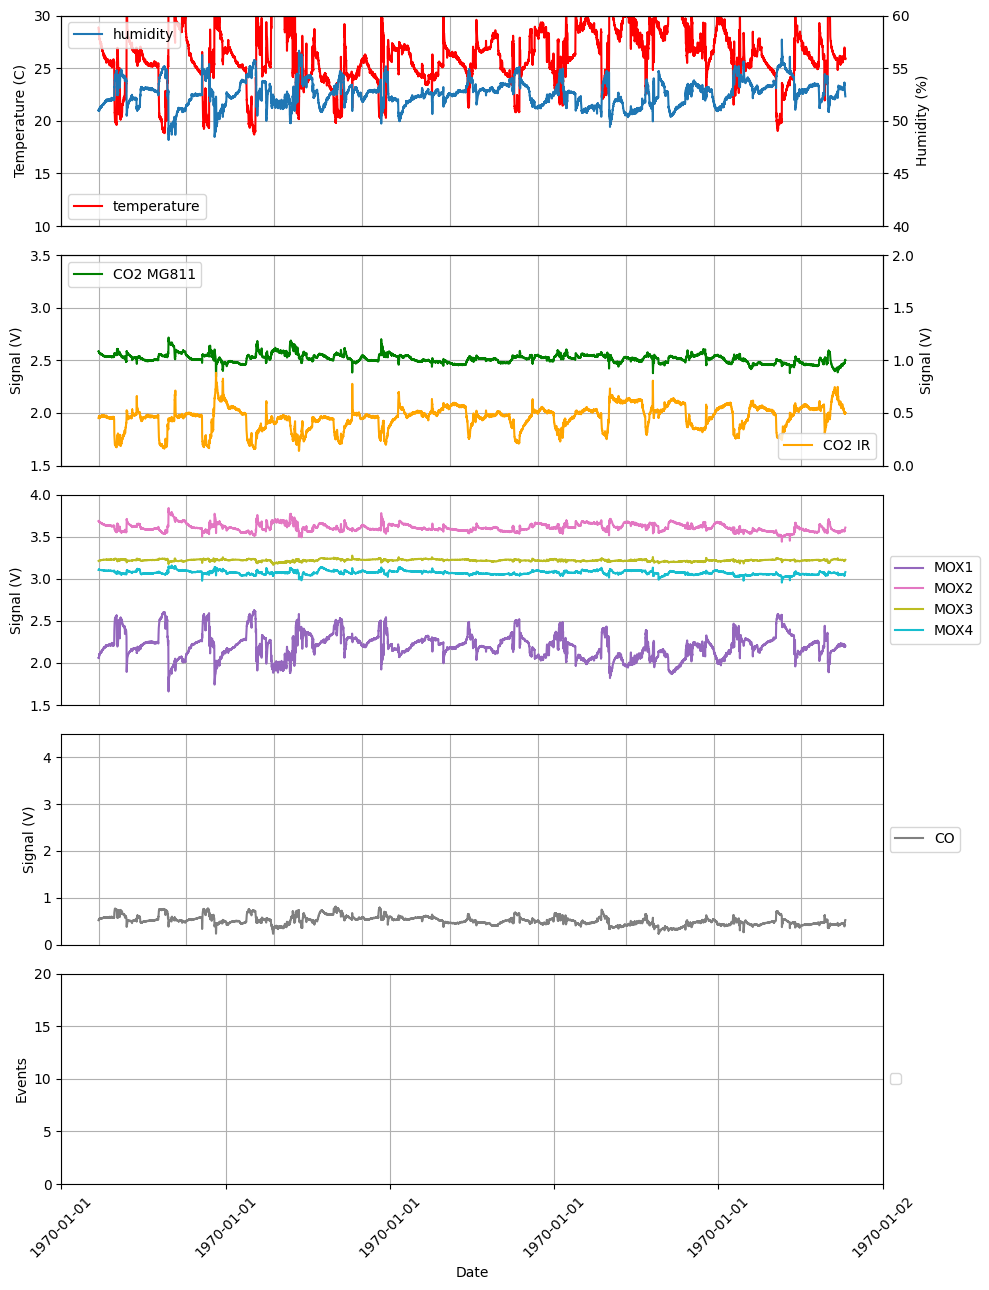

In [13]:
# selecting time interval of interest

visual_filtered_df = inv_transf_occupants.where("timestamp >= '2019-11-15' AND timestamp < '2019-12-02' ")
visual_filtered_df = visual_filtered_df.select([col(c) for c in columns_to_keep] + [F.round(col(c) / lit(V_divider), 4).alias(c) for c in columns_to_normalize])
visual_filtered_df = visual_filtered_df.orderBy('timestamp').toPandas()

# Create a figure and a grid of subplots
fig, axs = plt.subplots(5, 1, figsize=(10, 13))  # 4 rows, 1 column

# Plot the data in each subplot

axs[0].plot(visual_filtered_df['timestamp'], visual_filtered_df['temperature'], color='red', label='temperature')
axs[0].twin = axs[0].twinx()
axs[0].twin.plot(visual_filtered_df['timestamp'], visual_filtered_df['humidity'], label='humidity')
axs[0].twin.set_ylabel('Humidity (%)')
axs[0].set_ylabel('Temperature (C)')
axs[0].tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelbottom=False, labelleft=True)
axs[0].twin.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=True, labelbottom=False, labelleft=False)
axs[0].set_ylim(10, 30)
axs[0].twin.set_ylim(40, 60)
axs[0].grid(True)
axs[0].legend()
axs[0].twin.legend()

axs[1].plot(visual_filtered_df['timestamp'], visual_filtered_df['CO2MG811Value'], color='green', label='CO2 MG811')
axs[1].twin = axs[1].twinx()
axs[1].twin.plot(visual_filtered_df['timestamp'], visual_filtered_df['CO2CosIRValue'], color='orange', label='CO2 IR')
axs[1].twin.set_ylabel('Signal (V)')
axs[1].set_ylabel('Signal (V)')
axs[1].tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelbottom=False, labelleft=True)
axs[1].twin.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=True, labelbottom=False, labelleft=False)
axs[1].grid(True)
axs[1].set_ylim(1.5, 3.5)
axs[1].twin.set_ylim(0, 2)
axs[1].twin.legend(loc='lower right')
axs[1].legend(loc='upper left')

axs[2].plot(visual_filtered_df['timestamp'], visual_filtered_df['MOX1'], color='tab:purple', label='MOX1')
axs[2].plot(visual_filtered_df['timestamp'], visual_filtered_df['MOX2'], color='tab:pink', label='MOX2')
axs[2].plot(visual_filtered_df['timestamp'], visual_filtered_df['MOX3'], color='tab:olive', label='MOX3')
axs[2].plot(visual_filtered_df['timestamp'], visual_filtered_df['MOX4'], color='tab:cyan', label='MOX4')
axs[2].set_ylabel('Signal (V)')
axs[2].tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelbottom=False, labelleft=True)
axs[2].set_ylim(1.5, 4)
axs[2].grid(True)
axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axs[3].plot(visual_filtered_df['timestamp'], visual_filtered_df['COValue'], color='grey', label='CO')
axs[3].set_ylabel('Signal (V)')
axs[3].tick_params(axis='both', which='both', bottom=False, top=False, left=True, right=False, labelbottom=False, labelleft=True)
axs[3].set_ylim(0, 4.5)
axs[3].grid(True)   
axs[3].legend(loc='center left', bbox_to_anchor=(1, 0.5))


''' TODO add t-limit
axs[4].plot(visual_filtered_df['timestamp'], visual_filtered_df['COValue'], color='grey')  

'''
axs[4].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[4].set_ylabel('Events')
axs[4].grid(True)
axs[4].set_ylim(0, 20)
date_format = DateFormatter('%Y-%m-%d')
axs[4].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False, labelbottom=True, labelleft=True)
axs[4].xaxis.set_major_formatter(date_format)    
axs[4].tick_params(axis='x', labelrotation=45)
axs[4].set_xlabel('Date') 

#TODO at t-limit


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()